# Redes Completamente Conectadas

In [1]:
import pandas as pd
import numpy as np 
import keras

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix
import itertools

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [23]:
# inicializando o gerador de numeros aleatorios
# Com isso podemos sempre reproduzir os resultados
seed = 7
np.random.seed(seed)

## 1.1 Um exemplo introdutório

In [3]:
p = np.array([[0.4046, 0.9974, 0.3764, 0.6043],
             [0.3786, 0.8479, 0.9214, 0.3494],
             [0.7010, 0.6201, 0.9331, 0.1438],
             [0.8608, 0.4031, 0.7514, 0.6035],
             [0.5947, 0.9653, 0.6914, 0.4111]])
t = np.array( [0,1,0,1,1] )

p.shape, t.shape

((5, 4), (5,))

In [4]:
net = Sequential()
net.add(Dense(3, input_dim=4, kernel_initializer='normal', activation='sigmoid'))
net.add(Dense(1, activation='sigmoid'))
net.compile(loss='mean_squared_error', optimizer='sgd', metrics=['accuracy'])

history = net.fit(p,t, epochs=100000, verbose=0)

print(history.history.keys())

dict_keys(['loss', 'acc'])


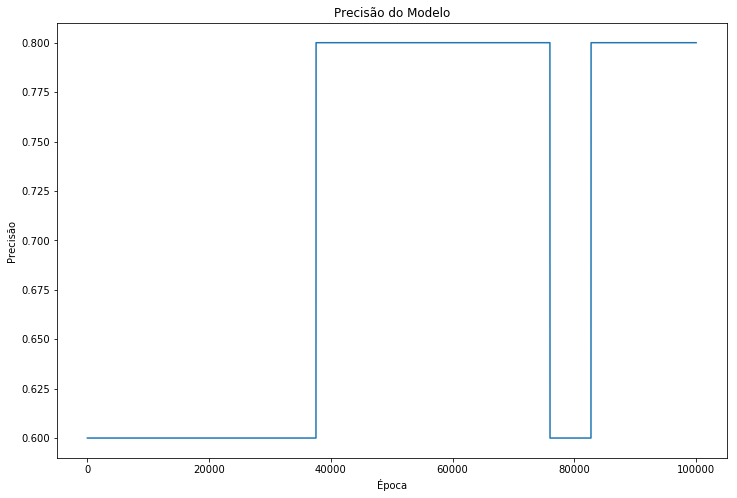

In [5]:
plt.figure(figsize=(12,8))
plt.plot(history.history['acc'])
plt.title('Precisão do Modelo')
plt.ylabel('Precisão')
plt.xlabel('Época')

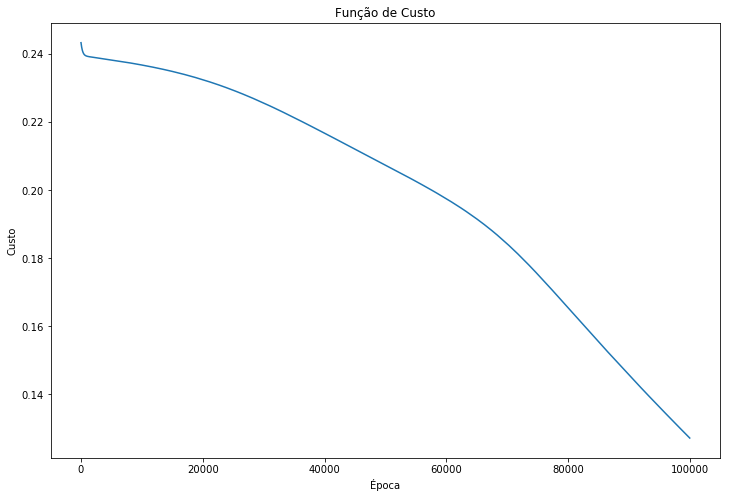

In [6]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'])
plt.title('Função de Custo')
plt.ylabel('Custo')
plt.xlabel('Época')

## 1.2 Criação de modelo de predição de crédito

In [7]:
colunas = ['ESCT','NDEP','RENDA', 'TIPOR', 'VBEM', 'NPARC', 'VPARC', 'TEL', 'IDADE', 'RESMS', 'ENTRADA', 'CLASSE']
data = pd.read_csv('dados/credtrain.txt', header=None, sep='\t', names=colunas)  
data.head()

,ESCT,NDEP,RENDA,TIPOR,VBEM,NPARC,VPARC,TEL,IDADE,RESMS,ENTRADA,CLASSE
0,1,0,360,0,313,9,52,0,25,48,0,1
1,0,0,350,1,468,10,65,0,33,6,0,1
2,0,0,1100,0,829,9,125,0,56,48,0,1
3,0,0,3000,0,552,12,76,1,31,60,0,1
4,1,0,1000,0,809,12,111,0,24,7,0,1


In [8]:
dataset = data.values
P = dataset[:,0:11].astype(float)
T = dataset[:,11]

P.shape, T.shape

((1500, 11), (1500,))

In [9]:
test = pd.read_csv('dados/credtest.txt', header=None, sep='\t', names=colunas)  
dataset_test = test.values

P_test = dataset_test[:,0:11].astype(float)
T_test = dataset_test[:,11]

encoder = LabelEncoder()
encoder.fit(T)
encoded_T = encoder.transform(T)

In [20]:
def criar_modelo():
    model = Sequential()
    model.add(Dense(16, input_dim=11, kernel_initializer='normal', activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Para rodar o modelo, primeiro foi necessário Normalizar os dados com o **StandardScaler do SckitLearn**

Depois para a tarefa de calssificação foi utilizado um classificado **MLP**. 

Para que o treinamento não fosse prejudicado pela distribuição dos dados, foi utilizado a tecnica **Kfold** estratificada, com embralhamento, desse modo a cada época uma fatia aleatória dos dados foi utilizada, sempre obedecendo as caracteristicas do conjunto (estratificado)

Por fim o resultado foi avaliado com validação cruzada.

In [11]:
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=criar_modelo, epochs=100, batch_size=300, verbose=0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(pipeline, P, encoded_T, cv=kfold)

print("Precisão: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

results

Precisão: 89.28% (2.76%)


### Matriz de Confusão

300/577 [==============>...............] - ETA: 0s

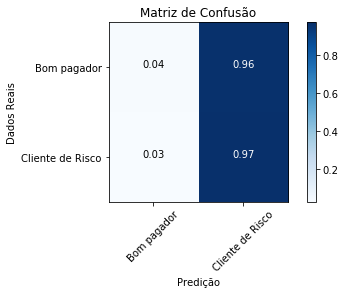

In [27]:
model = criar_modelo()
model.evaluate(P_test, T_test,verbose=0)
predicoes = model.predict_classes(P_test,batch_size=300)

classes = ['Bom pagador', 'Cliente de Risco']

#Matriz de confusao
cm = confusion_matrix(T_test,predicoes)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Matriz de Confusão")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

fmt = '.2f'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('Dados Reais')
plt.xlabel('Predição')
